In [ ]:
%pip install numpy

In [ ]:
%pip install pandas

In [ ]:
%pip install networkx

In [ ]:
%pip install matplotlib

In [ ]:
%pip install tqdm

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 
from tqdm import tqdm
from networkx.drawing.nx_pydot import graphviz_layout
from collections import Counter

# Base para todos

[other works](https://petsymposium.org/popets/2020/popets-2020-0023.pdf)

## Kalebe implementations

exponential mechanism

In [375]:
def exp_mechanism_k(data, score_func, list_outputs, epsilon, global_sensivity, target = None):
    scores = [score_func(data, out, target) if target != None else score_func(data, out) for out in list_outputs]
    probs = [np.exp(epsilon * score / (2 * global_sensivity)) for score in scores]
    probs_normalizadas = probs / np.linalg.norm(probs, ord=1)

    return np.random.choice(list_outputs, 1, p=probs_normalizadas)[0]

local dampening mechanism

In [528]:
def dampening_function_k(data, output, score_func, delta_func, target = None):
    b_list = [0]
    i = 0  
    b_list.append(delta_func(data, i, output) if target == None else delta_func(data, i, output, target))
    score = score_func(data, output, target) if target != None else score_func(data, output)
    # print(output)
    while True:
        if (score >= 0 and (score < b_list[-2] or score >= b_list[-1])) or (score < 0 and (score < -b_list[-1] or score >= -b_list[-2])):
            print(f"Não ainda\nb0:{b_list[-2]}\nb1:{b_list[-1]}\nscore:{score}\nOutput:{output}")
            i += 1
            d_func = delta_func(data, i, output) if target == None else delta_func(data, i, output, target)
            b_list.append(b_list[-1] + d_func)
            continue
        
        D_val = (score - b_list[-2]) / (b_list[-1] - b_list[-2]) + i if score > 0 else (score + b_list[-2]) / np.abs(-b_list[-1] + b_list[-2]) - i
        # print(D_val, b_list[-1], b_list[-2], score)
        # # plt.scatter(D_val, D_val + i)
        # plt.scatter([i for i in b_list], [ 1 + i for i in range(len(b_list))], color = "blue")
        # plt.scatter([-i for i in b_list], [ 1 - i for i in range(len(b_list))], color = "blue")
        # plt.title(f"Output: {output}")
        # plt.xlabel(f"local sensivity at t distânce")
        # plt.xlabel(f"local sensivity at t distânce")
        # plt.show()
        return D_val

def local_dampening_mechanism_k(data, score_func, delta_func, list_outputs, epsilon, target = None):
    scores = [dampening_function_k(data, out, score_func, delta_func, target) if target != None else dampening_function_k(data, out, score_func, delta_func) for out in list_outputs]
    probs = [np.exp(epsilon * score / 2) for score in scores]
    probs_normalizadas = probs / np.linalg.norm(probs, ord=1)
    return np.random.choice(list_outputs, 1, p=probs_normalizadas)[0]

# def shifted_local_dampening_mechanism(data, score_func, delta_func, list_outputs, epsilon, global_sensivity,target = None):
# s0 = n∆u+maxr0∈R u(x, r0)
#     len(data) * global_sensivity + 

permute and flip mechanism

In [443]:
def permute_and_flip_k(data, score_func, list_outputs, epsilon, global_sensivity, target = None):
    max_score = max([score_func(data, out, target) if target else score_func(data, out) for out in list_outputs])
    # aqui talvez seja interessante copiar e passar a copia da list_ouputs
    np.random.shuffle(list_outputs)
    for r in list_outputs:
        prob = np.exp(epsilon * (score_func(data, r, target) - max_score) / (2 * global_sensivity))
        if np.random.rand() < prob:
            return r

## Darlan implementations

In [548]:
def Local_Dampening_Mechanism(u_r, sensibilidade, r_id, G, target):
    if u_r >= 0:
        
        t = 0
        bt0 = 0
        bt1 = sensibilidade(G, 0, r_id, target)
        
        while True:
            if ((bt0 <= u_r) and  (u_r < bt1)):
                print("Saiu do loop", r_id)
                break
            print(f"Não ainda\nb0:{bt0}\nb1:{bt1}\nscore:{u_r}\nOutput:{r_id}")
            t += 1
            bt0 = bt1
            bt1 += sensibilidade(G, t, r_id, target)
    elif u_r < 0:

        t = 0
        bt0 = 0
        bt1 = -sensibilidade(G, 0, r_id, target)
        
        while True:

            if ((bt1 <= u_r) and  (u_r < bt0)):
                break
            
            t -= 1
            bt0 = bt1
            bt1 -= sensibilidade(G, -t, r_id, target)
    
    D = (u_r - bt0) / np.abs(bt1 - bt0) + t
    
    return D

def local_dampening_mechanism_d(data, score_func, delta_func, list_outputs, epsilon, target = None):
    scores = [Local_Dampening_Mechanism(score_func(data, out, target), delta_func, out, data, target) for out in list_outputs]
    probs = [np.exp(epsilon * score / 2) for score in scores]
    probs_normalizadas = probs / np.linalg.norm(probs, ord=1)
    return np.random.choice(list_outputs, 1, p=probs_normalizadas)[0]

# def local_dampening_mechanism_d(data, score_func, delta_func, list_outputs, epsilon, target = None):
#     scores = [Local_Dampening_Mechanism(score_func(data, out, target), delta_func, out, data, target) for out in list_outputs]
#     probs = [np.exp(epsilon * score / 2) for score in scores]
#     probs_normalizadas = probs / np.linalg.norm(probs, ord=1)
#     return np.random.choice(list_outputs, 1, p=probs_normalizadas)[0]


# Algoritmo 7

In [544]:
def get_canditates_alg7(data, t, value_column, target, coluna, label):
    recorte_Aj = data[data[coluna] == value_column]
    recorte_Ajc = recorte_Aj[recorte_Aj[target] == label]
    candidates = [(len(recorte_Aj), len(recorte_Ajc))]

    count = 0
    atual = 0
  
    while count < t:
        for candidate in candidates[atual:]:
            if candidate[0] > 0 and candidate[1] > 0:
                candidates.append((candidate[0] - 1, candidate[1] - 1))
                atual += 1
            if candidate[0]  < data.shape[0]:
                candidates.append((candidate[0] + 1, candidate[1]))
                atual += 1
        count += 1
    return candidates

def h_func(x, y):
    def f_func(x, somar = False):
        if (x <= 0 and somar) or (x <= 1 and not somar):
           return 0
        return x * np.log2((x + 1) / x) + np.log2(x + 1) if somar else x * np.log2((x - 1) / x) - np.log2(x - 1)
    return max(f_func(x, True) - f_func(y, True), f_func(x) - f_func(y))

def local_sensivity_at_tDistance_alg7(data:pd.DataFrame, t:float, col_val, target):
    '''
    data = dataframe

    t = distâncuia

    col_val = uma coluna do dataframe

    target_values = lista com todas saídas possíveis do label
    '''
    H = []
    for j_val in data[col_val].unique():
        recorte_Aj = data[data[col_val] == j_val]
        for c_val in recorte_Aj[target].unique():
            for x,y in get_canditates_alg7(data, t, j_val, target, col_val, c_val):
              H.append(h_func(x,y))
    return max(H)

In [124]:
car_data = pd.read_csv("./car_evalueate.csv")
car_data

buying  maint  doors persons lug_boot safety  class
0     vhigh  vhigh      2       2    small    low  unacc
1     vhigh  vhigh      2       2    small    med  unacc
2     vhigh  vhigh      2       2    small   high  unacc
3     vhigh  vhigh      2       2      med    low  unacc
4     vhigh  vhigh      2       2      med    med  unacc
...     ...    ...    ...     ...      ...    ...    ...
1723    low    low  5more    more      med    med   good
1724    low    low  5more    more      med   high  vgood
1725    low    low  5more    more      big    low  unacc
1726    low    low  5more    more      big    med   good
1727    low    low  5more    more      big   high  vgood

[1728 rows x 7 columns]

In [121]:
dict_data = {
    "Outlook": ["rain", "rain", "sun", "sun", "sun"],
    "Wind": ["strong", "weak", "strong", "weak", "strong"],
    "Decision": ["y", "n", "y", "n", "n"]
}

data_example = pd.DataFrame(dict_data)
data_example

Outlook    Wind Decision
0    rain  strong        y
1    rain    weak        n
2     sun  strong        y
3     sun    weak        n
4     sun  strong        n

In [523]:
def noisy_count(data: pd.DataFrame, target, epsilon):
    # Contagem exata da coluna alvo
    exact_count = data[target].shape[0]
    
    noise = np.random.laplace(scale=1/epsilon)
    
    # Adicionar o ruído ao contador exato
    noisy_count = exact_count + noise
    
    return noisy_count

# Equação 7.2
def score_func_alg7(data: pd.DataFrame, r_col, target):
    '''
    r_col = uma coluna específica do dataframe
    '''
    infGain_list = []
    for cel_val in data[r_col].unique():
        data_colR_valA = data[data[r_col] == cel_val]
        tau_j = data_colR_valA.shape[0]
        for class_val in data_colR_valA[target].unique():
            data_colR_valA_outC = data_colR_valA[data_colR_valA[target] == class_val]
            tau_jc = data_colR_valA_outC.shape[0]
            # tau_jc = len(data[(data[r_col] == cel_val) & (data[target] == class_val)])
            # print(np.log2(tau_jc / tau_j), tau_jc)
            infGain_list.append(tau_jc * np.log2(tau_jc / tau_j))
    return -sum(infGain_list)

def build_diff_PID3(data:pd.DataFrame, list_columns: list, target, profundidade, epsilon, pai = None):
    data_target_list = data[target].unique()
    if len(list_columns) == 0 or profundidade == 0:
        data_output_partitions = [noisy_count(data[data[target] == c], target, epsilon) for c in data_target_list]
        print(data_output_partitions)
        max_Nc = max(data_output_partitions)
        name_node = f"{data_target_list[data_output_partitions.index(max_Nc)]}:id:{profundidade}"
        return (name_node + f"{pai}") if pai else (name_node)
    t_val = max([len(data[col].unique()) for col in list_columns])
    N_t = noisy_count(data, target, epsilon)
    if N_t / (t_val * len(data_target_list)) < np.sqrt(2)/2:
        data_output_partitions = [noisy_count(data[data[target] == c], target, epsilon) for c in data_target_list]
        max_Nc = max(data_output_partitions)
        return (data_target_list[data_output_partitions.index(max_Nc)]) 
        
    # columns_hat = exp_mechanism_k(data, score_func_alg7, list_columns, epsilon, np.log2(data.shape[0] + 1) + 1/np.log(2), target)
    columns_hat = local_dampening_mechanism_k(data, score_func_alg7, local_sensivity_at_tDistance_alg7, list_columns, epsilon, target)
    # columns_hat = local_dampening_mechanism_d(data, score_func_alg7, local_sensivity_at_tDistance_alg7, list_columns, epsilon, target)
    data_i = [(data[data[columns_hat] == i], i ) for i in data[columns_hat].unique()]
    list_columns.remove(columns_hat)
    arvore = []
    for dado in data_i:
        root_node = build_diff_PID3(dado[0], list_columns, target, profundidade - 1, epsilon, columns_hat)
        arvore.append({
            "from": columns_hat,
            "to": root_node,
            "edge_name": dado[1]
        })
    
    return arvore

def global_diff_PID3(data:pd.DataFrame, target, profundidade: int, privacy_budget: float):
    '''
    data = um dataframe
    target = a coluna alvo, no exemplo do tempo, seria o Y e o N
    profundidade = numero que indica a profuntidade
    privacy_budget = nivel de privacidade numero
    '''
    epsilon = privacy_budget / (2 * (profundidade + 1))
    lista_colunas = data.columns.to_list()
    lista_colunas.remove(target)
    # print(data, lista_colunas, target, profundidade, epsilon)
    return build_diff_PID3(data, lista_colunas, target, profundidade, epsilon)

def molde2draw(molde):
    G = nx.DiGraph()
    lista_labels = {}

    def add_edge(from_name, to_name, edge_label):
        if isinstance(to_name, list):
            for item in to_name:
                to_name = item["from"]
                add_edge(item["from"], item["to"], item["edge_name"])
            
        G.add_edge(from_name, to_name)
        lista_labels[(from_name, to_name)] = edge_label

    for dict_node in molde:
        add_edge(dict_node["from"], dict_node["to"], dict_node["edge_name"])

    root = molde[0]["from"]
    pos = nx.bfs_layout(G, root)
    nx.draw(
        G, pos, edge_color='black', width=1, linewidths=1,
        node_size=500, node_color='pink', alpha=0.9,
        labels={node: node.split(":id:")[0] for node in G.nodes()}
    )
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=lista_labels,
        font_color='red'
    )
    plt.axis('off')
    plt.show()

Nesse caso, se o epsilon for muito grande, o score cresce para infinito e se for muito pequeno retorna somente um nó (no mecanismo exponencial, o outro nem roda)

Não ainda
b0:0
b1:1.2451124978365313
score:4.754887502163468
Output:Outlook
Não ainda
b0:1.2451124978365313
b1:3.9999999999999996
score:4.754887502163468
Output:Outlook
Não ainda
b0:0
b1:1.2451124978365313
score:2.754887502163469
Output:Wind
Não ainda
b0:0
b1:0.7548875021634682
score:2.0
Output:Wind
[0.926312945323167, 1.1581646532383578]
[1.120655271230529]


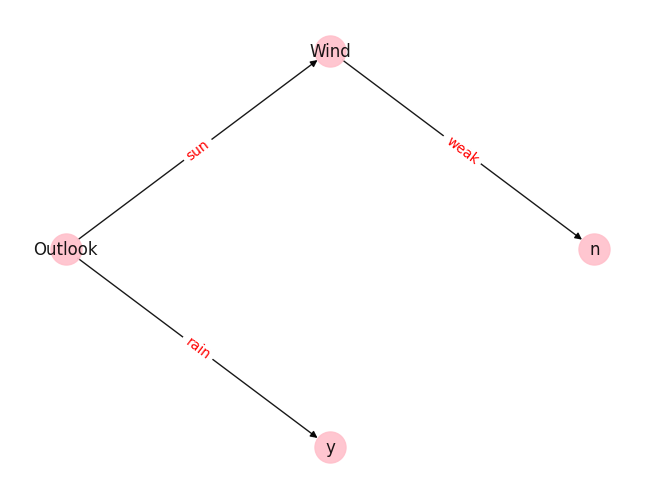

[{'from': 'Outlook', 'to': 'y', 'edge_name': 'rain'}, {'from': 'Outlook', 'to': [{'from': 'Wind', 'to': 'n:id:0Wind', 'edge_name': 'strong'}, {'from': 'Wind', 'to': 'n:id:0Wind', 'edge_name': 'weak'}], 'edge_name': 'sun'}]


In [545]:
# Atribua um valor de privacidade para o orçamento de privacidade
epsilon = 100

# Chame a função global_diff_PID3 para construir a árvore de decisão diferencial com privacidade global
arvore_molde = global_diff_PID3(data_example, "Decision", 2, epsilon)
molde2draw(arvore_molde)
print(arvore_molde)

Não ainda
b0:0
b1:4.202076014057061
score:1916.856577455946
Output:buying
Não ainda
b0:4.202076014057061
b1:8.463558101983395
score:1916.856577455946
Output:buying
Não ainda
b0:8.463558101983395
b1:12.728379764746153
score:1916.856577455946
Output:buying
Não ainda
b0:12.728379764746153
b1:16.996533289687584
score:1916.856577455946
Output:buying
Não ainda
b0:16.996533289687584
b1:21.268010999692198
score:1916.856577455946
Output:buying
Não ainda
b0:21.268010999692198
b1:25.54280525294186
score:1916.856577455946
Output:buying
Não ainda
b0:25.54280525294186
b1:29.820908442672657
score:1916.856577455946
Output:buying
Não ainda
b0:29.820908442672657
b1:34.10231299693444
score:1916.856577455946
Output:buying
Não ainda
b0:34.10231299693444
b1:38.38701137835202
score:1916.856577455946
Output:buying
Não ainda
b0:38.38701137835202
b1:42.67499608388932
score:1916.856577455946
Output:buying
Não ainda
b0:42.67499608388932
b1:46.96625964461487
score:1916.856577455946
Output:buying
Não ainda
b0:46.96

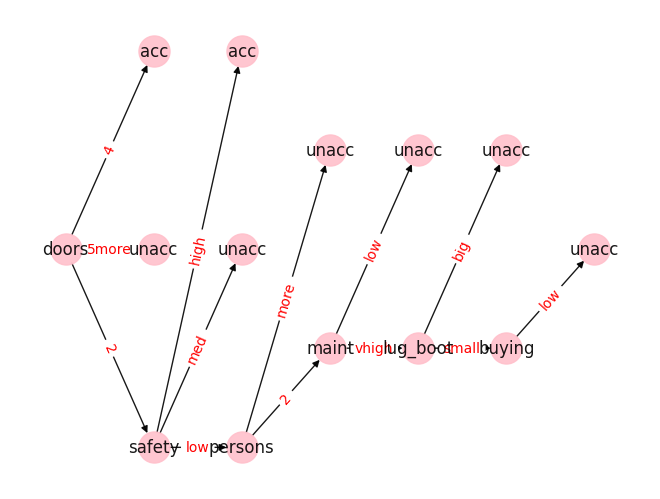

[{'from': 'doors', 'to': [{'from': 'safety', 'to': [{'from': 'persons', 'to': [{'from': 'maint', 'to': [{'from': 'lug_boot', 'to': [{'from': 'buying', 'to': 'unacc:id:0buying', 'edge_name': 'vhigh'}, {'from': 'buying', 'to': 'unacc:id:0buying', 'edge_name': 'high'}, {'from': 'buying', 'to': 'unacc:id:0buying', 'edge_name': 'med'}, {'from': 'buying', 'to': 'unacc:id:0buying', 'edge_name': 'low'}], 'edge_name': 'small'}, {'from': 'lug_boot', 'to': 'unacc:id:1lug_boot', 'edge_name': 'med'}, {'from': 'lug_boot', 'to': 'unacc:id:1lug_boot', 'edge_name': 'big'}], 'edge_name': 'vhigh'}, {'from': 'maint', 'to': 'unacc:id:2maint', 'edge_name': 'high'}, {'from': 'maint', 'to': 'unacc:id:2maint', 'edge_name': 'med'}, {'from': 'maint', 'to': 'unacc:id:2maint', 'edge_name': 'low'}], 'edge_name': '2'}, {'from': 'persons', 'to': 'unacc:id:3persons', 'edge_name': '4'}, {'from': 'persons', 'to': 'unacc:id:3persons', 'edge_name': 'more'}], 'edge_name': 'low'}, {'from': 'safety', 'to': 'unacc:id:4safety'

In [549]:
epsilon = 1/10
# Chame a função global_diff_PID3 para construir a árvore de decisão diferencial com privacidade global
arvore_molde = global_diff_PID3(car_data, "class", 6, epsilon)
print(car_data['class'].unique())
# print(arvore_molde)
molde2draw(arvore_molde)
print(arvore_molde)

Não ainda
b0:0
b1:2.1417094500762923
score:248.03027925076447
Output:age
Não ainda
b0:2.1417094500762923
b1:6.041843979966417
score:248.03027925076447
Output:age
Não ainda
b0:6.041843979966417
b1:10.18355343004271
score:248.03027925076447
Output:age
Não ainda
b0:10.18355343004271
b1:14.532068975639481
score:248.03027925076447
Output:age
Não ainda
b0:14.532068975639481
b1:19.061393988620292
score:248.03027925076447
Output:age
Não ainda
b0:19.061393988620292
b1:23.751349924513104
score:248.03027925076447
Output:age
Não ainda
b0:23.751349924513104
b1:28.58581678064975
score:248.03027925076447
Output:age
Não ainda
b0:28.58581678064975
b1:33.551618984293356
score:248.03027925076447
Output:age
Não ainda
b0:33.551618984293356
b1:38.63778531147368
score:248.03027925076447
Output:age
Não ainda
b0:38.63778531147368
b1:43.83503788444594
score:248.03027925076447
Output:age
Não ainda
b0:43.83503788444594
b1:49.13542790976726
score:248.03027925076447
Output:age
Não ainda
b0:49.13542790976726
b1:54.5

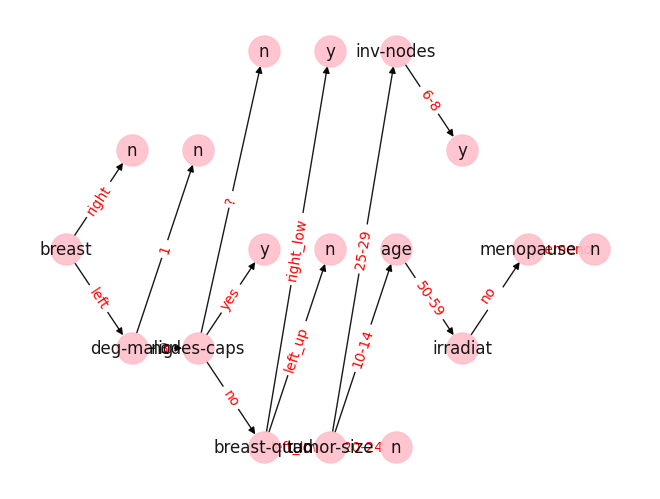

[{'from': 'breast', 'to': [{'from': 'deg-malig', 'to': [{'from': 'nodes-caps', 'to': [{'from': 'breast-quad', 'to': [{'from': 'tumor-size', 'to': 'n', 'edge_name': '30-34'}, {'from': 'tumor-size', 'to': [{'from': 'age', 'to': [{'from': 'irradiat', 'to': [{'from': 'menopause', 'to': 'n:id:0menopause', 'edge_name': 'premeno'}], 'edge_name': 'no\n'}], 'edge_name': '50-59'}], 'edge_name': '10-14'}, {'from': 'tumor-size', 'to': 'n', 'edge_name': '35-39'}, {'from': 'tumor-size', 'to': 'n', 'edge_name': '20-24'}, {'from': 'tumor-size', 'to': [{'from': 'inv-nodes', 'to': 'y:id:2inv-nodes', 'edge_name': '6-8'}], 'edge_name': '25-29'}], 'edge_name': 'left_low'}, {'from': 'breast-quad', 'to': 'n:id:4breast-quad', 'edge_name': 'central'}, {'from': 'breast-quad', 'to': 'n:id:4breast-quad', 'edge_name': 'right_up'}, {'from': 'breast-quad', 'to': 'n:id:4breast-quad', 'edge_name': 'left_up'}, {'from': 'breast-quad', 'to': 'y:id:4breast-quad', 'edge_name': '?'}, {'from': 'breast-quad', 'to': 'y:id:4bre

In [547]:
epsilon = 10
# Chame a função global_diff_PID3 para construir a árvore de decisão diferencial com privacidade global

row = []
with open("./breast-cancer.data") as f:
    for r in f:
        row.append(r.split(","))

cancer_data = pd.DataFrame(row, columns = ["Class", "age", "menopause", "tumor-size", "inv-nodes", "nodes-caps", "deg-malig", "breast", "breast-quad", "irradiat"])
cancer_data = cancer_data.replace({"recurrence-events":"y", "no-recurrence-events":"n"})

arvore_molde = global_diff_PID3(cancer_data, "Class", 8, epsilon)
molde2draw(arvore_molde)
print(arvore_molde)

# Algoritmo 5

saida: o indíce do valor mais próximo da mediana

entrada: vetor x, com todos valores entre 0 e $\Lambda$

In [456]:
def local_sensivity_at_0_alg5(x:list, idx:int, param):
    m = param[1]
    def p(x, i):
        if i > m:
            return param[0] - x[i]
        if i == m:
            return param[0] - x[m + 1]
        return param[0] + x[i] - 3 * x[m] + x[m + 1]
    def q(x,i):
        if i > m:
            return x[i]
        if i == m:
            return x[m - 1]
        return 3 * x[m] - x[m - 1] - x[i]
    
    values = [np.abs(x[m] - x[idx]), x[m + 1] - x[m], x[m] - x[m - 1], p(x,idx), q(x,idx)]

    return max(values)

def copy_and_replace(x, idx, val):
    new_x = x.copy()
    if not idx and not val: return new_x
    new_x[idx] = val
    return np.sort(new_x)
    
def get_canditates_alg5(x, t, idx, param):
    if t == 0:
        return [x]
    m = int(np.ceil((len(x))/2))
    if t == 1:
        X = []
        X.append(x, idx, param[0])
        X.append(x)
        X.append(x, idx, 0)
        X.append(x)
        X.append(x, m, param[0])
        X.append(x, m, 0)
        return X
    X = get_canditates_alg5(x, t - 1, idx, param[0])
    return [copy_and_replace(i, m, param[0]) if m % 2 == 1 else copy_and_replace(i, m, 0) for i in X]

def local_sensivity_at_tDistance_alg5(x, t, i, param):
    list_candidates = get_canditates_alg5(x, t, i, param)
    return max([local_sensivity_at_0_alg5(candidate, i, param) for candidate in list_candidates])

def score_func_alg5(x, idx, param):
    m = param[1]
    return -np.abs(x[m] - x[idx])

## Avalaiando

In [438]:
def avaliation(x, score_func, list_outputs, epsilon_range, max_u = None, n_amostras = 10000, typo_mech = "exp", delta_func = None):
    evaluate = {}
    for epsilon in tqdm(epsilon_range, desc="Processando epsilons", unit=" valor"):
        if typo_mech == "exp":
            evaluate[epsilon] = [exp_mechanism_k(x, score_func, list_outputs, epsilon, max_u[0], max_u) for i in range(n_amostras)]
        elif typo_mech == "paf":
            evaluate[epsilon] = [permute_and_flip_k(x, score_func, list_outputs, epsilon, max_u[0], max_u) for i in range(n_amostras)]
        elif typo_mech == "ld":
            evaluate[epsilon] = [local_dampening_mechanism_k(x, score_func, delta_func, list_outputs, epsilon, max_u) for i in range(n_amostras)]
        
    return evaluate

In [434]:
epsilons = np.linspace(10**-3, 10**3, 100)
n_array = 10000
lam = 10**6
percent = 50
quantil = int(np.ceil(percent/ 100 * n_array))
parameters = [lam, quantil]
array_aleatorio = np.sort(np.random.randint(0, lam, n_array))
n_amostras = 10000
list_outputs = [i for i in range(n_array)]
max_utility = max(score_func_alg5(array_aleatorio, i, parameters) for i in range(n_array))

### exponencial mechanism

In [468]:
evalueate_exp = avaliation(array_aleatorio, 
                           score_func_alg5, 
                           list_outputs, 
                           epsilons, 
                           parameters, 
                           typo_mech = "exp",
                           n_amostras=n_amostras)

Processando epsilons:   0%|          | 0/100 [00:00<?, ? valor/s]

Processando epsilons: 100%|██████████| 100/100 [02:52<00:00,  1.72s/ valor]


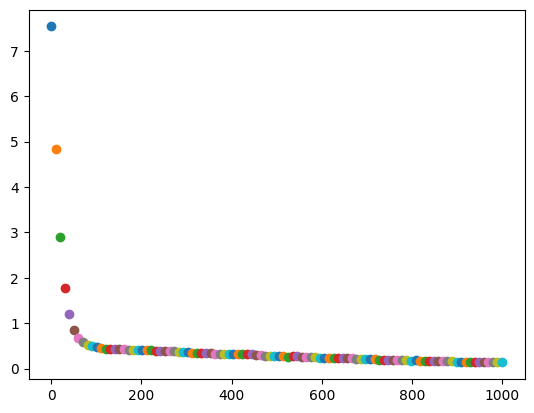

In [469]:
for ep, err in evalueate_exp.items():
    erro_abs = [np.abs(quantil - i) for i in err]
    mean_err = np.mean(erro_abs)
    plt.scatter(ep, mean_err)
plt.show()

In [498]:
for ep, err in evalueate_exp.items():
    error = [max_utility - i for i in err]
    print(error)

0
[-22, -8, -1, -20, -16, -17, -11, -10, -7, -9, -16, -25, -6, -10, -20, -18, -14, -12, -5, -9, -10, -28, -17, -3, -15, -17, -26, -22, -23, -21, -16, -6, -4, -5, -27, -24, -2, -12, -19, -28, -25, -17, -10, -22, -18, -3, -19, -29, -29, -8, -14, -20, -15, -9, -24, 0, -4, -9, -29, -12, -27, -14, -29, -13, -8, -18, -7, -2, -17, -28, -11, -18, -1, -15, -25, -15, -13, -26, -20, -13, 0, 0, -23, -11, -9, -23, -24, -20, -13, -7, -22, -26, -26, -23, -8, -18, -14, -27, -7, -29, -28, -28, -8, -22, -21, -4, -29, -1, -3, -19, -20, -3, -20, -20, -27, -18, -23, -17, -6, -4, -6, -7, -1, -19, -6, 0, -9, -15, -11, -28, -10, -11, -28, -10, -8, -27, -17, -20, -12, -9, -28, -24, -8, -21, -15, -9, -10, -18, -7, -26, -13, -4, -20, -2, -18, -1, -23, -4, -12, 0, -1, 0, -6, -9, -23, -9, -16, 0, -13, -26, -13, -6, -27, -2, -15, -2, -23, -12, -15, -1, -17, -28, -19, -26, -21, -5, -21, -14, -3, -3, -9, -24, -13, -20, -8, -10, -21, -28, 0, -16, -8, 0, -15, -1, -17, -5, -27, -8, -14, -13, -20, -10, -26, -24, -21, -14

### permuta and flip

In [470]:
evalueate_paf = avaliation(x = array_aleatorio, 
                           score_func = score_func_alg5, 
                           list_outputs = list_outputs, 
                           epsilon_range = epsilons, 
                           max_u = parameters, 
                           typo_mech = "paf",
                           n_amostras=n_amostras)

Processando epsilons:   0%|          | 0/100 [00:00<?, ? valor/s]

Processando epsilons: 100%|██████████| 100/100 [01:41<00:00,  1.01s/ valor]


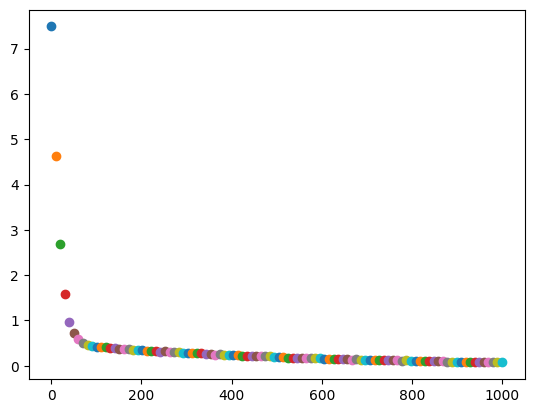

In [471]:
for ep, err in evalueate_paf.items():
    erro_abs = [np.abs(quantil - i) for i in err]
    mean_err = np.mean(erro_abs)
    plt.scatter(ep, mean_err)
plt.show()

### Local Dampening

In [472]:
evalueate_ld = avaliation(array_aleatorio, 
                          score_func_alg5, 
                          list_outputs, 
                          epsilons, 
                          parameters, 
                          typo_mech = "ld", 
                          delta_func=local_sensivity_at_tDistance_alg5,
                          n_amostras=n_amostras)

Processando epsilons:   0%|          | 0/100 [00:00<?, ? valor/s]

Processando epsilons: 100%|██████████| 100/100 [06:33<00:00,  3.94s/ valor]


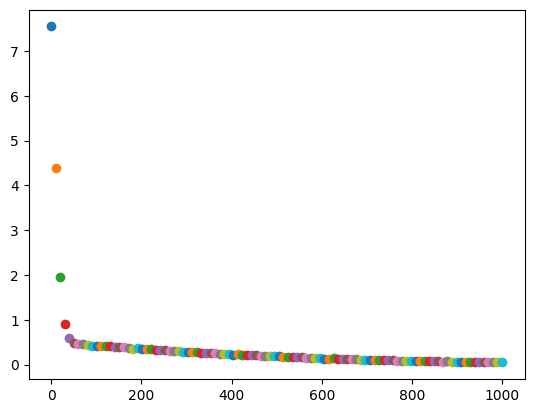

In [473]:
for ep, err in evalueate_ld.items():
    erro_abs = [np.abs(quantil - i) for i in err]
    mean_err = np.mean(erro_abs)
    plt.scatter(ep, mean_err)
plt.show()